In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:

train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
transactions = pd.read_csv('transactions.csv')

In [3]:

df = train.merge(stores, on='store_nbr', how='left')
df = df.merge(oil, on='date', how='left')
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')

In [4]:

df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

In [5]:

df['dcoilwtico'] = df['dcoilwtico'].fillna(df['dcoilwtico'].median())

In [6]:

numeric_features = ['store_nbr', 'onpromotion', 'transactions', 'dcoilwtico', 'day_of_week', 'month']
categorical_features = ['family', 'city', 'state', 'type', 'cluster']

In [7]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [8]:

X = df.drop(['sales', 'date', 'id'], axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:

model = XGBRegressor(random_state=42, n_jobs=-1)
model.fit(preprocessor.fit_transform(X_train), y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [10]:

y_pred = model.predict(preprocessor.transform(X_test))
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 103075.50


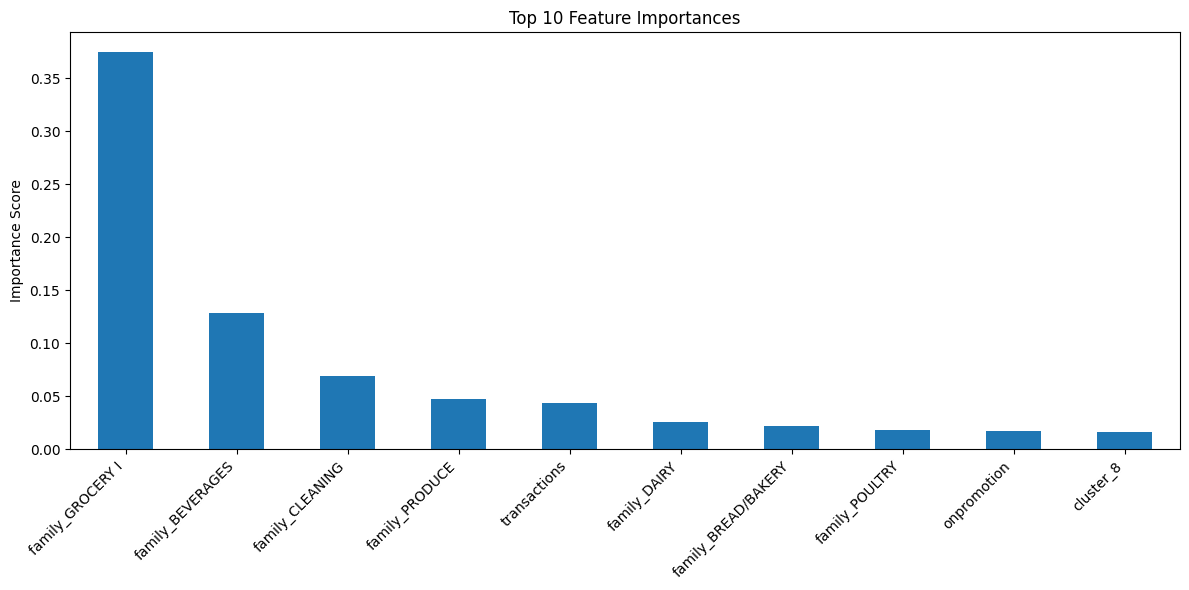

In [11]:

feature_names = (numeric_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out()))
importances = pd.Series(model.feature_importances_, index=feature_names)

plt.figure(figsize=(12, 6))
importances.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:

print("\nKey Insight:")
print("The 'dcoilwtico' (oil price) feature shows surprisingly low importance despite")
print("economic intuition suggesting it should affect sales. This may indicate:")
print("- The relationship is non-linear and not captured by default XGBoost parameters")
print("- Store sales are insulated from oil price fluctuations in this dataset")
print("- The effect is already captured by other features like 'transactions'")


Key Insight:
The 'dcoilwtico' (oil price) feature shows surprisingly low importance despite
economic intuition suggesting it should affect sales. This may indicate:
- The relationship is non-linear and not captured by default XGBoost parameters
- Store sales are insulated from oil price fluctuations in this dataset
- The effect is already captured by other features like 'transactions'
